In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tools.project_tools import *


2022-12-01 15:09:32.565639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 15:09:32.659866: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 15:09:32.663559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 15:09:32.663570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

First, clean up the data set to make testing easier. Importantly, analysing data from too far in the past is not very applicable to today's markets, e.g. NYA in the 1960's. Further, some stock exchanges do not have data that far in the past, either due to lack of data or the exchange not existing. Thus to allow for cross comparison of exchanges we will normalise the data sets such that they all start in the 2000's.

In [2]:
df = pd.read_csv("indexProcessed.csv")
var = "2005-01-01"
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.strftime('%Y-%m-%d')) >= var]
null_volume = 0
df.query("Volume != @null_volume", inplace=True)

Split the main data set into sub sets for each exchange.

In [3]:
# list of all indexes
index_list = []

# create folder for splitting the original csv 
if not os.path.exists("data_by_index"): os.makedirs("data_by_index")
# split the original csv into index only
for (index), group in df.groupby('Index'):
     group.to_csv(f'data_by_index/{index}.csv', index=False)
     index_list.append({index})

# example csv split
pd.read_csv("data_by_index/NYA.csv").set_index("Date")

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
2005-01-03,NYA,7250.060059,7268.209961,7174.000000,7179.709961,7179.709961,1.505900e+09,7179.709961
2005-01-04,NYA,7179.709961,7191.240234,7084.149902,7090.520020,7090.520020,1.721000e+09,7090.520020
2005-01-05,NYA,7090.520020,7103.520020,7055.089844,7055.209961,7055.209961,1.736800e+09,7055.209961
2005-01-06,NYA,7055.220215,7095.990234,7052.819824,7076.939941,7076.939941,1.569100e+09,7076.939941
2005-01-07,NYA,7076.939941,7102.790039,7039.410156,7057.509766,7057.509766,1.477900e+09,7057.509766
...,...,...,...,...,...,...,...,...
2021-05-24,NYA,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450
2021-05-25,NYA,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450
2021-05-26,NYA,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940


Since this projects concerns the relationship between Tokyo and NYC, we shall consider these two sets. We define the log return function and the return function to analyse if a particular day was "UP" or "DOWN".

In [4]:
nya_df = pd.read_csv("data_by_index/NYA.csv").set_index("Date")
tko_df = pd.read_csv("data_by_index/N225.csv").set_index("Date")


# insert log returns to each dataset
nya_df.insert(8, "Daily Log Returns", lg_return(nya_df)[0])
nya_df.insert(9, "Overall Forecast", lg_return(nya_df)[1])
tko_df.insert(8, "Daily Log Returns", lg_return(tko_df)[0])
tko_df.insert(9, "Overall Forecast", lg_return(tko_df)[1])

Finally, we shall even out the data frames such that they have the same dates, this will make combining the dataset easier.

In [5]:
even_out_frames(tko_df, nya_df)
tko_df

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Daily Log Returns,Overall Forecast,Delta Log Volume,Overall Vol Forecast
Date,,,,,,,,,,,,
2005-01-04,N225,11458.26953,11547.01953,11431.57031,11517.75000,11517.75000,41000000.0,115.177500,0.005178,UP,0.404058,UP
2005-01-05,N225,11458.91992,11461.09961,11416.96973,11437.51953,11437.51953,77500000.0,114.375195,-0.001869,DOWN,0.404058,UP
2005-01-06,N225,11372.34961,11492.25977,11372.20996,11492.25977,11492.25977,87100000.0,114.922598,0.010489,UP,0.404058,UP
2005-01-07,N225,11528.69043,11528.69043,11432.19043,11433.24023,11433.24023,72300000.0,114.332402,-0.008314,DOWN,0.404058,DOWN
2005-01-11,N225,11495.45996,11580.69043,11495.45996,11539.99023,11539.99023,87800000.0,115.399902,0.003866,UP,0.404058,UP
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,N225,28212.32031,28584.17969,28212.32031,28364.60938,28364.60938,54700000.0,283.646094,0.005383,UP,0.404058,DOWN
2021-05-25,N225,28516.99023,28576.97070,28443.74023,28553.98047,28553.98047,54000000.0,285.539805,0.001296,UP,0.404058,DOWN
2021-05-26,N225,28396.61914,28710.83008,28396.61914,28642.18945,28642.18945,64200000.0,286.421895,0.008611,UP,0.404058,UP


We shall now add the relevant Tokyo data to the main New York data. Note that due to the timezone difference, Tokyo's Open is the next day for NYA. Thus we have to shift the Tokyo data by one before adding it to the nya dataset.  

In [6]:
tko_close = tko_df["Close"]

nya_df.insert(10, "Prev Tokyo Close", tko_close)


tko_df.drop(index=tko_df.index[0], inplace=True)

tko_open = tko_df["Open"]

tko_open = np.append(tko_open,0)

tko_open_forecast = tko_df["Overall Forecast"]

tko_open_forecast =  np.append(tko_open_forecast,0)

tko_vol_forecast = tko_df["Overall Vol Forecast"]

tko_vol_forecast = np.append(tko_vol_forecast, 0)


nya_df.insert(11, "Next Tokyo Open", tko_open)
nya_df.insert(12, "Next Tokyo Forecast", tko_open_forecast)
nya_df.drop(index=nya_df.index[len(nya_df) - 1], inplace=True)

<AxesSubplot: xlabel='Volume', ylabel='Next Tokyo Open'>

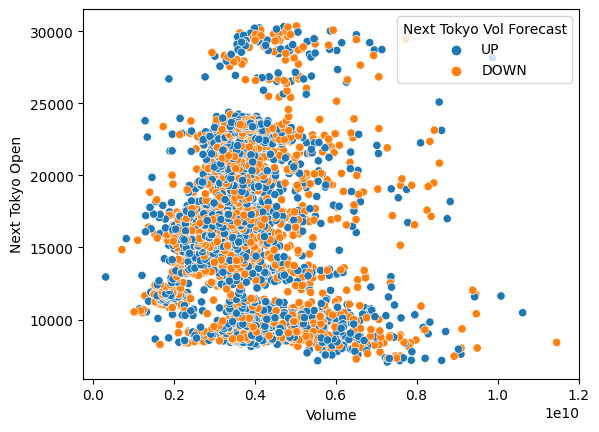

In [8]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Volume", hue="Next Tokyo Vol Forecast")
# plt.savefig("figures/Vol")

<AxesSubplot: xlabel='Close', ylabel='Next Tokyo Open'>

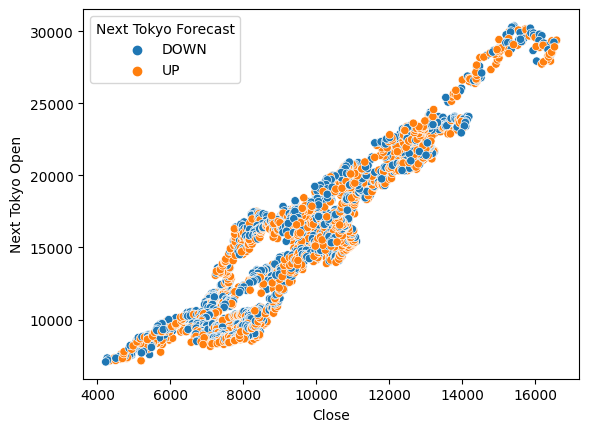

In [9]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Close", hue="Next Tokyo Forecast")
# plt.savefig("figures/Close")

<AxesSubplot: xlabel='Daily Log Returns', ylabel='Next Tokyo Open'>

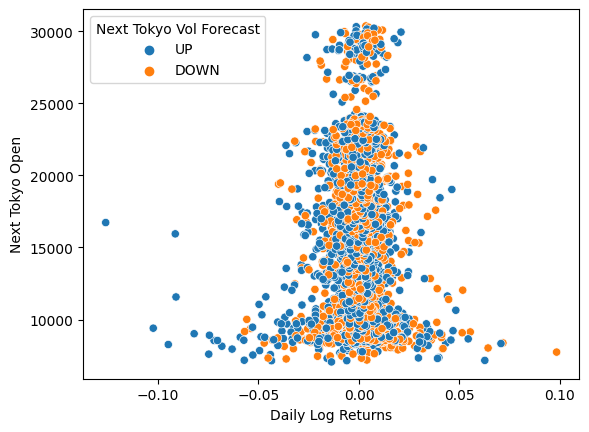

In [10]:
sns.scatterplot(data=nya_df, y="Next Tokyo Open", x="Daily Log Returns", hue="Next Tokyo Vol Forecast")
# plt.savefig("figures/LgR")

Finally, we remove redundant columns and scale the remaining data down to allow for more efficient training.

In [11]:
TEST_SIZE = 0.20

min_max_scaler = MinMaxScaler()

Removed_Cols = ["Index", "CloseUSD", "Adj Close", "Daily Log Returns", "Overall Forecast",  "Next Tokyo Forecast"]

scaled_data =  min_max_scaler.fit_transform(nya_df.drop(columns=Removed_Cols).values)

y_data = scaled_data[:, 6]
 
x_data = np.delete(scaled_data,  5, axis=1)

nya_train, nya_test, tko_open_train, tko_open_test = train_test_split(x_data,
                                                      y_data, 
                                                      test_size=TEST_SIZE,
                                                      shuffle=False)

nya_train= np.reshape(nya_train, (nya_train.shape[0], nya_train.shape[1], 1))

scaled_data.shape

(3853, 8)

In [12]:
MAX_EPOCH = 10

NUMBER_OF_RUNS = 5

predictions_lstm, model_history_lstm, prediction_error_lstm = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "LSTM", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)


predictions_gru, model_history_gru, prediction_error_gru = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "GRU", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)


predictions_lstm_gru, model_history_lstm_gru, prediction_error_lstm_gru = evaluate(nya_train, tko_open_train, nya_test, tko_open_test, 
        "LSTM_GRU", MAX_EPOCH, NUMBER_OF_RUNS, min_max_scaler)

2022-12-01 15:10:09.632741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 15:10:09.632760: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 15:10:09.632771: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (linux-laptop): /proc/driver/nvidia/version does not exist
2022-12-01 15:10:09.632929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
3082/3082 [==============================] - 14s 4ms/step - loss: 7.0844e-04 - root_mean_squared_error: 0.0266 - val_loss: 2.4015e-04 - val_root_mean_squared_error: 0.0155
Epoch 2/10
1611/3082 [==============>...............] - ETA: 5s - loss: 7.5670e-05 - root_mean_squared_error: 0.0087

KeyboardInterrupt: 

In [ ]:
_, gru_avg = analysis_by_epoch(model_history_gru, MAX_EPOCH)

_, lstm_avg = analysis_by_epoch(model_history_lstm, MAX_EPOCH)

_, lstm_gru_avg = analysis_by_epoch(model_history_lstm_gru, MAX_EPOCH)

In [ ]:
gru_avg = pd.DataFrame(gru_avg)
lstm_avg = pd.DataFrame(lstm_avg)
lstm_gru_avg = pd.DataFrame(lstm_gru_avg)

In [14]:
ax = gru_avg.plot(y="average root_mean_squared_error")
gru_avg.plot(ax=ax, y="average val_root_mean_squared_error")
lstm_avg.plot(ax=ax, y="average root_mean_squared_error")
lstm_avg.plot(ax=ax, y="average val_root_mean_squared_error")

NameError: name 'gru_avg' is not defined

In [ ]:
lstm_avg

,average loss,average root_mean_squared_error,average val_loss,average val_root_mean_squared_error
0,0.006420,0.080108,0.007279,0.081766
1,0.003083,0.055511,0.002150,0.046342
2,0.001012,0.031357,0.000770,0.027006
3,0.000074,0.008528,0.000416,0.020089
4,0.000042,0.006495,0.000187,0.013454
5,0.000029,0.005306,0.000034,0.005530
6,0.000022,0.004655,0.000108,0.009890
7,0.000024,0.004898,0.000020,0.004453
8,0.000015,0.003918,0.000023,0.004746


In [ ]:
lstm_gru_avg

,average loss,average root_mean_squared_error,average val_loss,average val_root_mean_squared_error
0,0.007459,0.086355,0.007496,0.084157
1,0.003488,0.059051,0.002810,0.052791
2,0.000352,0.018613,0.000347,0.017104
3,0.000076,0.008687,0.000102,0.009964
4,0.000031,0.005520,0.000096,0.009705
5,0.000026,0.005067,0.000108,0.009904
6,0.000109,0.010323,0.000489,0.018111
7,0.000055,0.007359,0.000114,0.008590
8,0.000143,0.011626,0.000042,0.006500
